In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import sys
import time
import glob

import numpy as np
import matplotlib.pyplot as plt

import PIL
import imageio
from IPython import display

import tensorflow as tf
from tensorflow.keras import layers

os.environ["CUDA_VISIBLE_DEVICES"]="0"

/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages

In [2]:
# Training Flags (hyperparameter configuration)
model_name = 'ppca'
train_dir = os.path.join('train', model_name, 'exp1')
dataset_name = 'mnist'
assert dataset_name in ['mnist', 'fashion_mnist']
height = 28
width = 28
dim = height * width
reduced_dim = 2

In [3]:
# Load training and eval data from tf.keras
if dataset_name == 'mnist':
  (train_images, train_labels), _ = \
      tf.keras.datasets.mnist.load_data()
else:
  (train_images, train_labels), _ = \
      tf.keras.datasets.fashion_mnist.load_data()

train_images = train_images.reshape(-1, 28, 28, 1).astype('float32')
#train_images = train_images / 255. # Normalize the images to [0, 1]
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

(60000, 28, 28, 1)


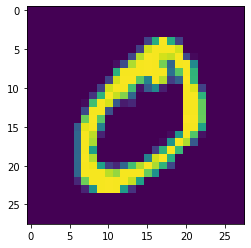

In [4]:
print(train_images.shape)
plt.imshow(train_images[1, :, :, 0])
plt.show()

In [5]:
train_labels
print(train_labels==1)

[False False False ... False False False]


In [6]:
X = train_images.reshape([-1, dim])
print(X.shape)
print(X[0])

(60000, 784)
[-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.        

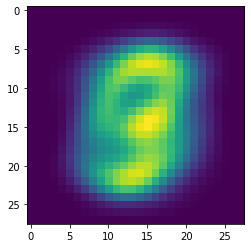

In [7]:
mu = np.mean(X, axis=0)[:, None]
plt.imshow(mu.reshape([height, width]))


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


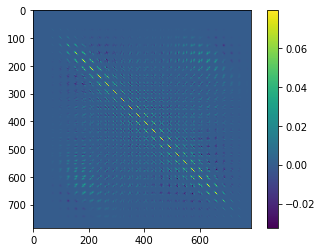

In [8]:
from tqdm import tqdm_notebook as tqdm

S = np.zeros((dim, dim))

for x in tqdm(X[::10]):
    # x : (dim)
    x = x[:, None] # (dim, 1)
    s = (x - mu) @ (x - mu).T
    S += s
S /= len(X)

print(S)
plt.imshow(S)
plt.colorbar()
plt.show()

In [9]:
from numpy import linalg as LA
from scipy.sparse.linalg import svds

w, v = LA.eig(S)
w = abs(w)
v = abs(v)
print(w.shape, v.shape)

(784,) (784, 784)


In [10]:
U = v[:, :reduced_dim]
print(U.shape)

variance = np.sum(w[reduced_dim:]) / (dim - reduced_dim) 
print(variance)

L = np.diag((w[:reduced_dim] - variance) ** 0.5)
print(L)

W = U @ L @ np.eye(reduced_dim)
print(W.shape)

(784, 2)
0.02172649272481912
[[1.40741472 0.        ]
 [0.         1.18082065]]
(784, 2)


In [11]:
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

(600, 2)


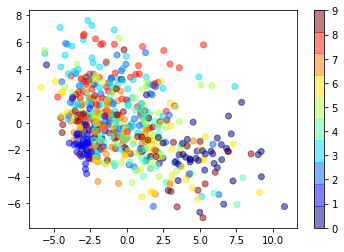

In [12]:
from numpy.linalg import inv

M = W.T @ W + variance * np.eye(reduced_dim)
M_inv = inv(M)

Z = []
labels = []
for index in range(0, len(X), 100):
    x = X[index]
    x = x[:, None]
    z = M_inv @ W.T @ (x - mu)
    Z.append(z[:, 0])
    labels.append(train_labels[index])
    
Z = np.stack(Z)
labels = np.stack(labels)

print(Z.shape)
plt.scatter(Z[:, 0], Z[:, 1], c=labels, cmap=discrete_cmap(10, 'jet'), alpha=0.5)
plt.colorbar()
plt.show()

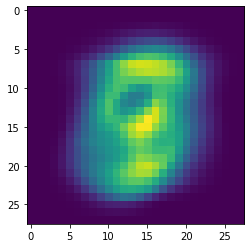

In [13]:
z = np.random.randn(2, 1)
x = W @ z + mu

plt.imshow(x.reshape((height, width)))
plt.show()

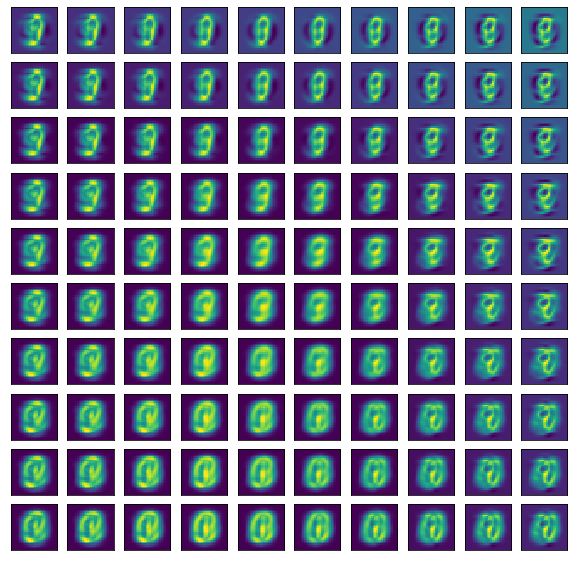

In [21]:
x_grid = np.linspace(-5, 5, 10)
y_grid = np.linspace(5, -5, 10)
xv, yv = np.meshgrid(x_grid, y_grid)
Z = np.stack([xv, yv], axis=2)

plt.figure(figsize=[10, 10])
for x_index in range(10):
    for y_index in range(10):
        z = Z[x_index][y_index][:, None]
        x = (W @ z + mu)[:, 0]
        
        plt.subplot(10, 10, x_index + 1 + y_index * 10)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.imshow(x.reshape((height, width)))
        
plt.show()
        